In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean, median
from math import sqrt
from scipy.stats import mannwhitneyu
from typing import Tuple, List, Dict, Set, Iterable
import matplotlib.style as mpl_style
import os
import json


In [3]:
# path to csv results
AIRFOIL_PATH = "./results.csv"

In [4]:
def df_from_path(path: str) -> pd.DataFrame:
    return pd.read_csv(
        filepath_or_buffer=path,
        sep="?",
    )

AIRFOIL_RESULTS = df_from_path(AIRFOIL_PATH)
AIRFOIL_RESULTS.tail()

directory rund_id  test_no  generation  \
1142  benchmark_runtime_daegp  5_3387        5          26   
1143  benchmark_runtime_daegp  5_3387        5          27   
1144  benchmark_runtime_daegp  5_3387        5          28   
1145  benchmark_runtime_daegp  5_3387        5          29   
1146  benchmark_runtime_daegp  5_3387        5          30   

      after_selection_depth_25percentile  after_selection_depth_50percentile  \
1142                                 0.0                                 0.0   
1143                                 0.0                                 0.0   
1144                                 1.0                                 3.0   
1145                                 0.0                                 1.0   
1146                                 0.0                                 0.0   

      after_selection_depth_75percentile after_selection_depth_algorithm  \
1142                                 0.0                        DAE_LSTM   
1143                                 0.0                        DAE_LSTM   
1144                                 5.0                        DAE_LSTM   
1145                                 8.0                        DAE_LSTM   
1146                                 0.0                        DAE_LSTM   

      after_selection_depth_avg  \
1142                      0.078   
1143                      0.160   
1144                      3.500   
1145                      3.864   
1146                      0.102   

      after_selection_depth_avg_lev_distance_denoising  ...  training_error  \
1142                                             0.048  ...           0.011   
1143                                             0.086  ...           0.014   
1144                                             0.408  ...           0.014   
1145                                             0.580  ...           0.015   
1146                                             0.054  ...            0.02   

      training_errors  training_mode unique  unique_output_vector_rate  \
1142             None    convergence     65                      0.106   
1143             None    convergence    405                      0.726   
1144             None    convergence    263                      0.488   
1145             None    convergence     42                      0.082   
1146             None    convergence     63                      0.104   

      unique_output_vector_rate_int  unique_output_vector_rate_sel  \
1142                          0.076                           0.05   
1143                          0.404                          0.066   
1144                          0.260                           0.43   
1145                          0.046                           0.29   
1146                          0.050                           0.06   

     unique_output_vector_rate_test  unique_rate  \
1142                          0.106        0.130   
1143                          0.726        0.810   
1144                          0.488        0.526   
1145                          0.082        0.084   
1146                          0.104        0.126   

      wass_norm_lev_div_sampled_vs_selected  
1142                                   0.15  
1143                                  0.146  
1144                                  0.094  
1145                                  0.116  
1146                                  0.071  

[5 rows x 787 columns]

In [5]:
def split_df(df: pd.DataFrame, dir1: str, dir2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df.query("directory == @dir1").copy(), df.query("directory == @dir2").copy()
    
pt_results, reg_results = split_df(AIRFOIL_RESULTS, "pt_dae_gp", "benchmark_runtime_daegp")
gp_results, _ = split_df(AIRFOIL_RESULTS, "gp", "benchmark_runtime_daegp")



In [6]:

print(
    pt_results.shape,
    reg_results.shape,
    gp_results.shape

)


(310, 787) (217, 787) (310, 787)


In [7]:
def filter_df_by_headers(df, headers):
    return df[df.columns.intersection(headers)]

In [8]:
def get_test_nums(df) -> Set[int]:
    return {x for x in df.test_no}

pt_test_nums = get_test_nums(pt_results)
reg_test_nums = get_test_nums(reg_results)
gp_test_nums = get_test_nums(reg_results)

def get_rund_ids(df) -> Set[int]:
    return {x for x in df.rund_id}

pt_rund_ids = get_rund_ids(pt_results)
reg_rund_ids = get_rund_ids(reg_results)
gp_rund_ids = get_rund_ids(gp_results)

PT_NRUNS = len(pt_rund_ids)
REG_NRUNS = len(reg_rund_ids)
GP_NRUNS = len(gp_rund_ids)

print(f"Pre-Trained Runs: {PT_NRUNS}\nRegular Runs: {REG_NRUNS}\nGP Runs: {GP_NRUNS}")

Pre-Trained Runs: 10
Regular Runs: 7
GP Runs: 10


In [9]:
D = {
    "hidden_layers": 2,
    "gen_max": 30,
    "n_runs": 10
}

def validate(D: Dict, df: pd.DataFrame, gp: bool=False):

    def check_hidden_layers(df: pd.DataFrame, value: str) -> bool:
        return all(df['hidden_layers'] == value)

    if not gp:
        print("Correct number of Hidden Layers: ", check_hidden_layers(df, D["hidden_layers"]))


    def check_generations_range(df: pd.DataFrame, minimum: int, maximum: int) -> bool:
        return all(df['generation'] >= minimum) and all(df['generation'] <= maximum)

    print("Correct number of Generations: ", check_generations_range(df, 0, D["gen_max"]))

    def get_ind_rund_ids(df):
        return len({x for x in df.rund_id})

    print("Minimum number of Runs reached: ", get_ind_rund_ids(df) >= D["n_runs"])


print("Regular Results:\n...")
validate(D, reg_results) 
print("\nPre-trained Results:\n...")
validate(D, pt_results)
print("\nGP Results:\n...")
validate(D, gp_results, gp=True)
print()



Regular Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  False

Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True

GP Results:
...
Correct number of Generations:  True
Minimum number of Runs reached:  True



In [10]:
def get_vals(df, vals, gens):

    ret = []

    def filter_df_by_col_val(df, col, val):
        return df[df[col] == val]

    def get_rund_ids(df) -> Set[int]:
        return {x for x in df.rund_id}
    
    run_ids = get_rund_ids(df)

    for i, id in enumerate(run_ids):

        _df = filter_df_by_col_val(df, "rund_id", id)

        ret.append([])

        for gen in range(0,gens+1):

            __df = filter_df_by_col_val(_df, "generation", gen)

            ret[i].append(
                __df[vals].values[0]
            )
    return ret


reg_fits = get_vals(reg_results, "best_fitness", 30)
reg_fits_test = get_vals(reg_results, "best_fitness_test", 30)

pt_fits = get_vals(pt_results, "best_fitness", 30)
pt_fits_test = get_vals(pt_results, "best_fitness_test", 30)

gp_fits = get_vals(gp_results, "best_fitness", 30)
gp_fits_test = get_vals(gp_results, "best_fitness_test", 30)


def get_means(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(mean(gen_fits))

    return ret
        


reg_fits_mean = get_means(reg_fits)
reg_fits_test_mean = get_means(reg_fits_test)

pt_fits_mean = get_means(pt_fits)
pt_fits_test_mean = get_means(pt_fits_test)

gp_fits_mean = get_means(gp_fits)
gp_fits_test_mean = get_means(gp_fits_test)


def get_medians(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(median(gen_fits))

    return ret


reg_fits_med = get_medians(reg_fits)
reg_fits_test_med = get_medians(reg_fits_test)

pt_fits_med = get_medians(pt_fits)
pt_fits_test_med = get_medians(pt_fits_test)

gp_fits_med = get_medians(gp_fits)
gp_fits_test_med = get_medians(gp_fits_test)

In [11]:
DATAPATH = "/Users/rmn/masterThesis/master_thesis/data/airfoil_2hl_maxIndSize_fullRun_30gens_TimeBenchmark"

def writeMWU(dir_name: str, file_name:str, sample1: Iterable, sample2: Iterable):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    statistic, pval = mannwhitneyu(x=sample1, y=sample2)

    S = {
        "statistic" : statistic,
        "p-value"   : pval
    }
    print(S)

    json.dump(
        S,
        open(os.path.join(dir_name, f"{file_name}.json"), "w", encoding="utf-8"),
    )

In [12]:
from json import load

MPL_CONFIG = load(
    open("/Users/rmn/masterThesis/eda-gp-2020/experiments/matplotlib_config.json", "r", encoding="utf-8")
)


mpl_style.use(MPL_CONFIG["mpl_style"])

# font sizes
SMALL=MPL_CONFIG["fonts"]["small"]
MID=MPL_CONFIG["fonts"]["mid"]
BIG=MPL_CONFIG["fonts"]["big"]

# color codes
C_REG=MPL_CONFIG["colors"]["dae-gp"]
C_PT=MPL_CONFIG["colors"]["pt_dae-gp"]
C_GP=MPL_CONFIG["colors"]["gp"]

# marker codes
M_TRAIN=MPL_CONFIG["marker"]["train"]
M_TEST=MPL_CONFIG["marker"]["test"]

TRAIN_LINESTYLE=MPL_CONFIG["train_line_style"]

DPI=MPL_CONFIG["dpi"]


IMG_PATH=f"{MPL_CONFIG['image_base_path']}/airfoil_2hl_maxIndSize_fullRun_30gens_TimeBenchmark"

def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

create_dir(IMG_PATH)
BASE_TITLE="Airfoil 2 Hidden Layers"

{'statistic': 31.0, 'p-value': 7.735613663190712e-12}


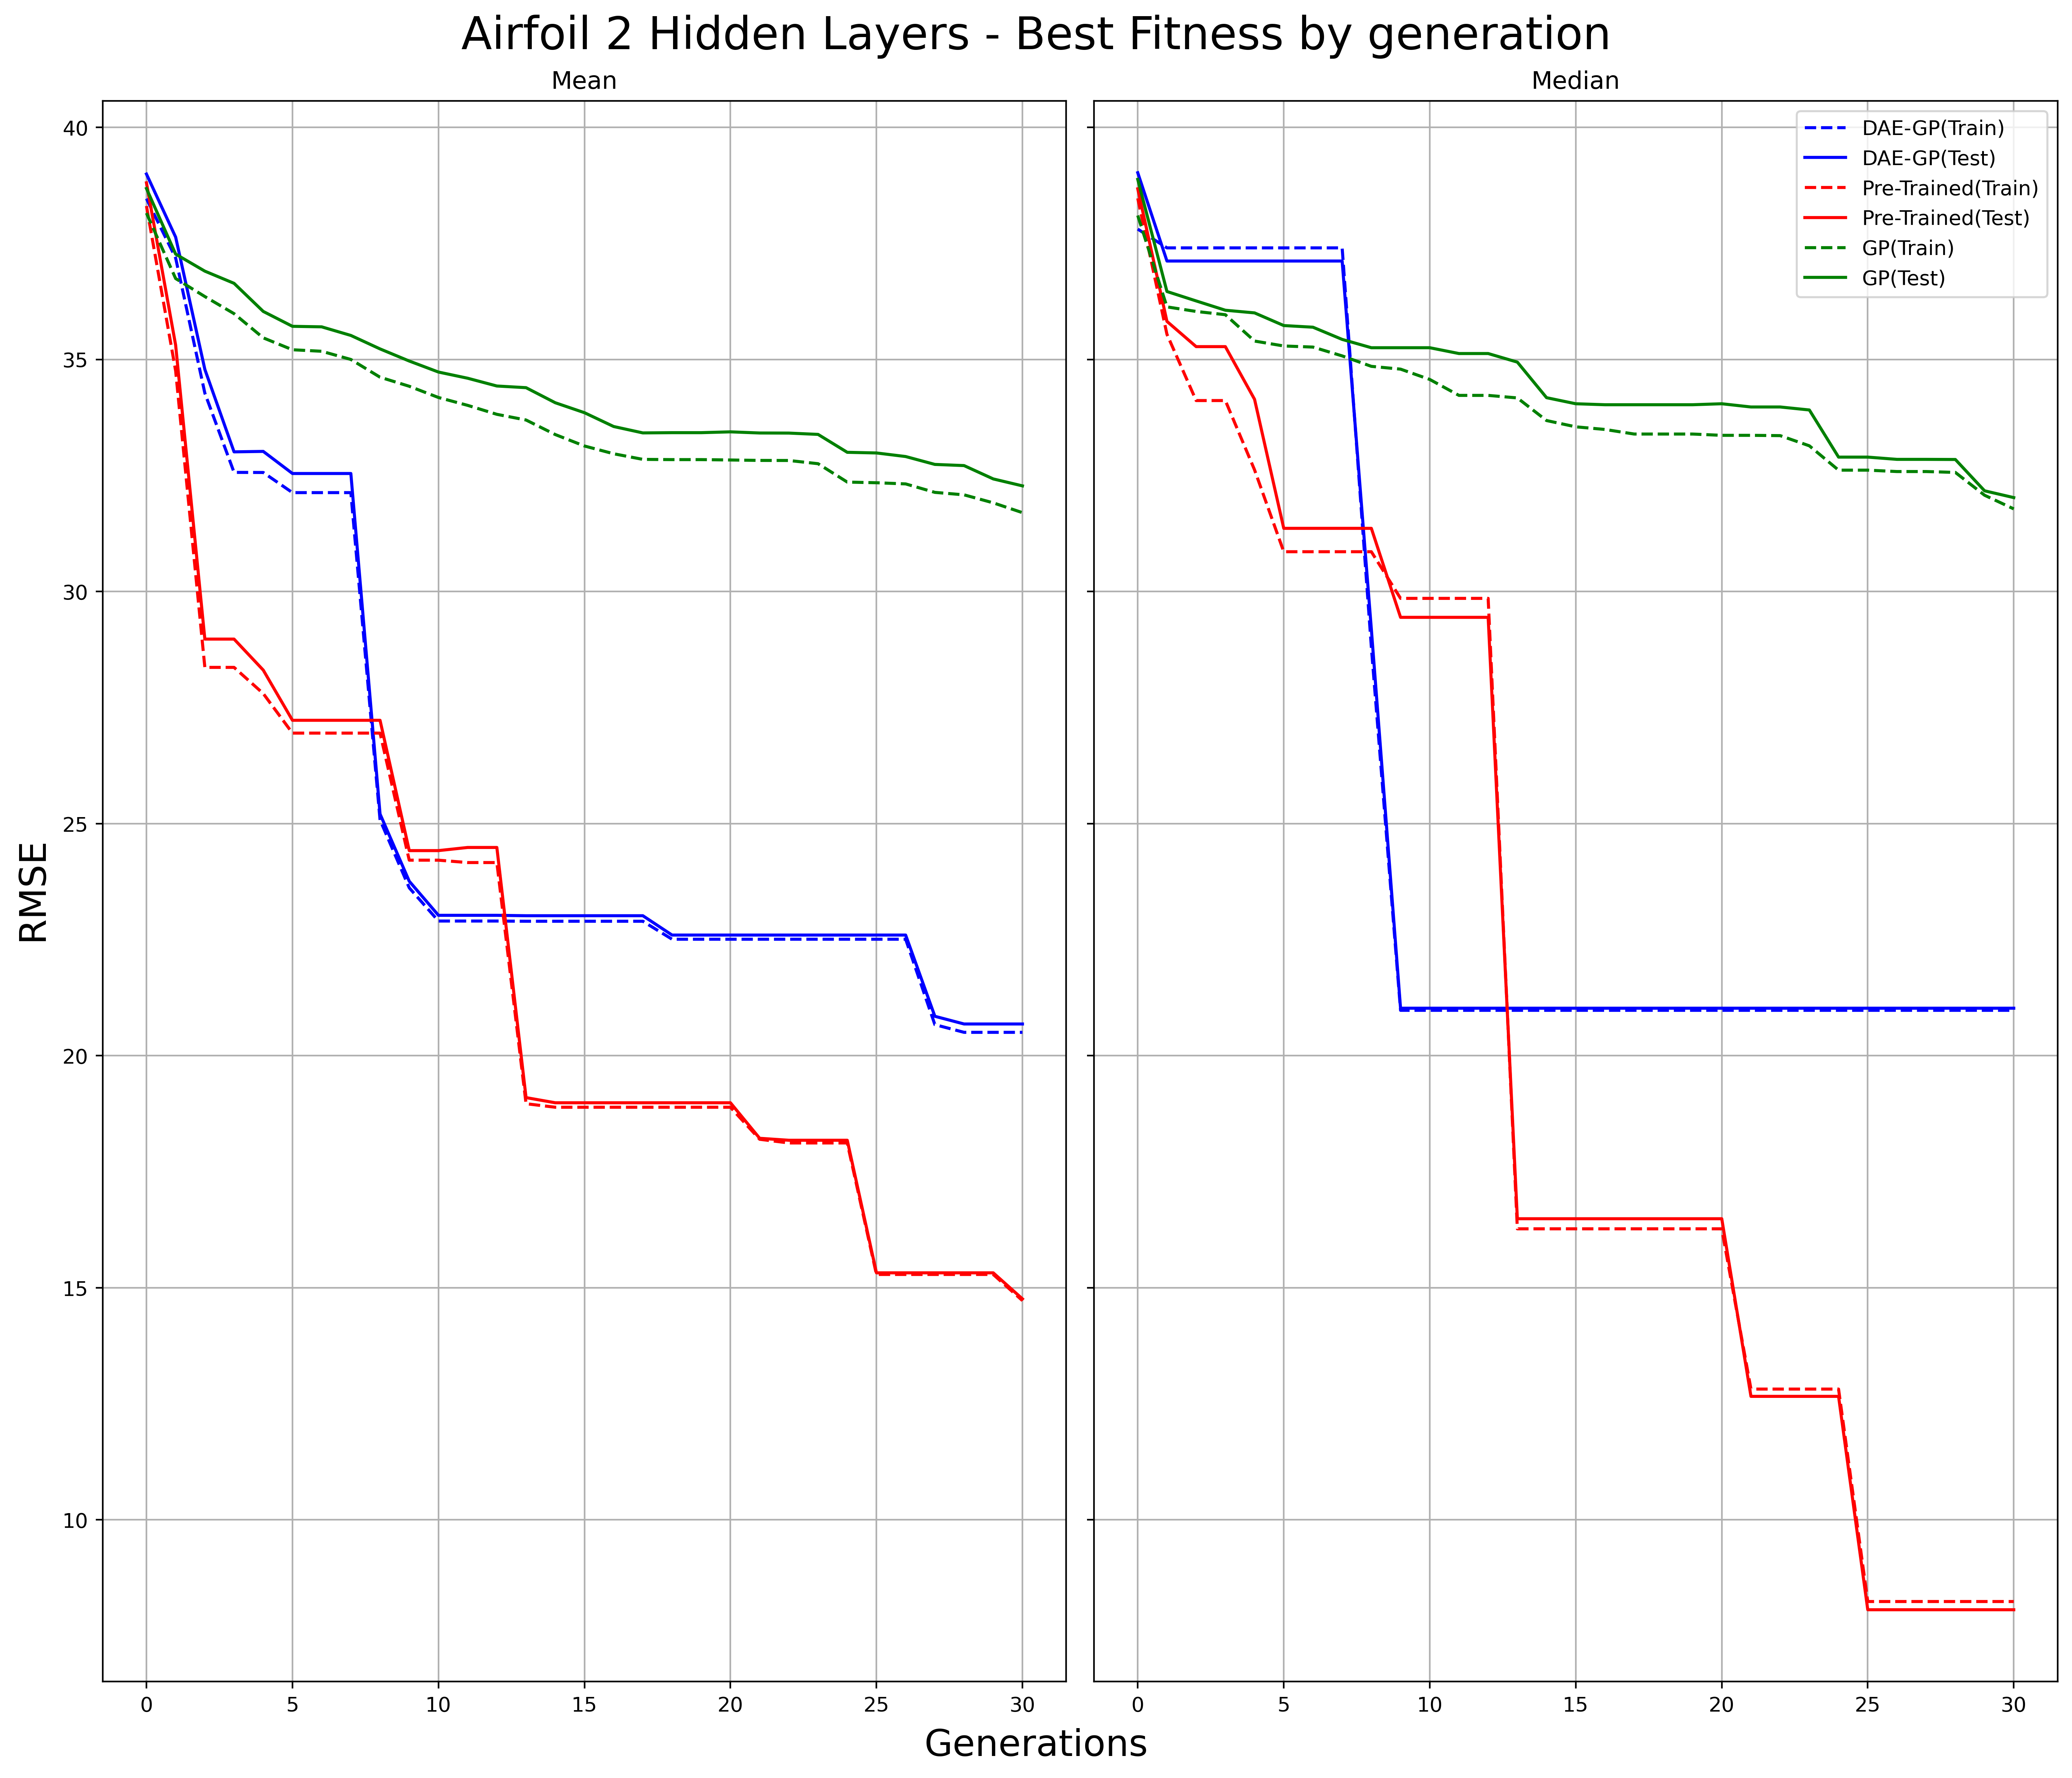

In [13]:
fig, (axl, axr) = plt.subplots(ncols=2, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]



fig.suptitle(f"{BASE_TITLE} - Best Fitness by generation", fontsize=BIG)
fig.supxlabel("Generations", fontsize=MID)
fig.supylabel("RMSE", fontsize=MID)

axl.set_title(f"Mean")
axl.plot(gens, reg_fits_mean, color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
axl.plot(gens, reg_fits_test_mean, color=C_REG, marker=M_TEST, label="DAE-GP(Test)")
axl.plot(gens, pt_fits_mean, color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Train)")
axl.plot(gens, pt_fits_test_mean, color=C_PT, marker=M_TEST, label="Pre-Trained(Test)")
axl.plot(gens, gp_fits_mean, color=C_GP, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="GP(Train)")
axl.plot(gens, gp_fits_test_mean, color=C_GP, marker=M_TEST, label="GP(Test)")
axl.grid()

axr.set_title("Median")
axr.plot(gens, reg_fits_med, color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
axr.plot(gens, reg_fits_test_med, color=C_REG, marker=M_TEST, label="DAE-GP(Test)")
axr.plot(gens, pt_fits_med, color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Train)")
axr.plot(gens, pt_fits_test_med, color=C_PT, marker=M_TEST, label="Pre-Trained(Test)")
axr.plot(gens, gp_fits_med, color=C_GP, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="GP(Train)")
axr.plot(gens, gp_fits_test_med, color=C_GP, marker=M_TEST, label="GP(Test)")
axr.grid()

axr.legend()


fig.savefig(f"{IMG_PATH}/mean_median_fitness_byGens.png")
writeMWU(DATAPATH, "MWU-BestFitnessByGen", pt_fits[0], reg_fits[0])

In [14]:
# def last_fits(arr):
#     ret = []
#     for run in arr:
#         ret.append(run[-1])
#     return ret

# fig, ax = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
# fig.set_size_inches(14,12)

# LABELS = ["DAE-GP(Train)", "DAE-GP(Test)", "Pre-Trained(Train)", "Pre-Trained(Test)", "GP(train)", "GP(test)"]
# X = [
#     last_fits(reg_fits),
#     last_fits(reg_fits_test),
#     last_fits(pt_fits),
#     last_fits(pt_fits_test),
#     last_fits(gp_fits),
#     last_fits(gp_fits_test)

# ]

# std_dev = np.std(X, 1)
# means = np.mean(X,1)

# fig.suptitle(f"{BASE_TITLE} - Best Fitness after 30 gens", fontsize=BIG)
# fig.supylabel("RMSE", fontsize=MID)

# bp_dict = ax.boxplot(
#     x=X,
#     labels=LABELS,
#     #patch_artist=True,  # fill with color
#     #notch=True,  # notch shape
# )

# for i, line in enumerate(bp_dict['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' mean={:.2f}\n std_dev={:.2f}'.format(means[i], std_dev[i])
#     ax.annotate(text, xy=(x, y))

# ax.grid()
# fig.savefig(f"{IMG_PATH}/final_fit_boxplot.png")

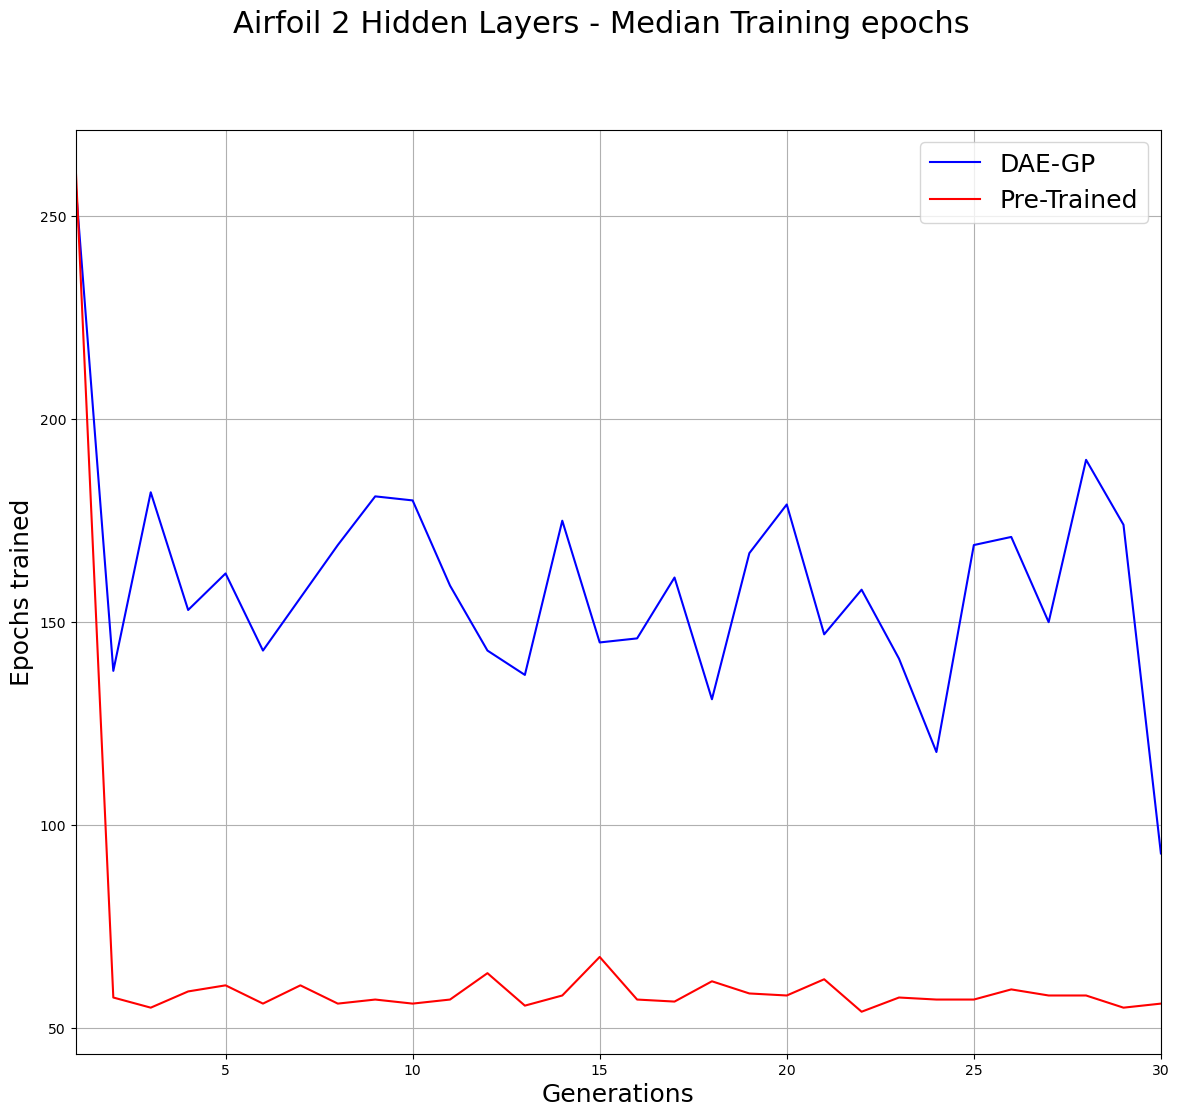

In [15]:
# epochs trained


reg_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(reg_results, "epochs_trained", 30)))
)
pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(pt_results, "epochs_trained", 30)))
)

gens = np.arange(1,31)

reg_epochs_mean = np.median(reg_epochs, axis=0)
pt_epochs_mean = np.median(pt_epochs, axis=0)

fig,ax = plt.subplots()
fig.set_size_inches(14,12)

fig.suptitle(f"{BASE_TITLE} - Median Training epochs", fontsize=BIG)

#ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=1, right=30)
    
ax.plot(gens, reg_epochs_mean[1:], color=C_REG, label="DAE-GP")
ax.plot(gens, pt_epochs_mean[1:], color=C_PT, label="Pre-Trained")

ax.set_ylabel("Epochs trained", fontsize=MID)
ax.set_xlabel("Generations", fontsize=MID)


ax.grid()
ax.legend(fontsize=MID)

fig.savefig(f"{IMG_PATH}/median_training_epochs.png")



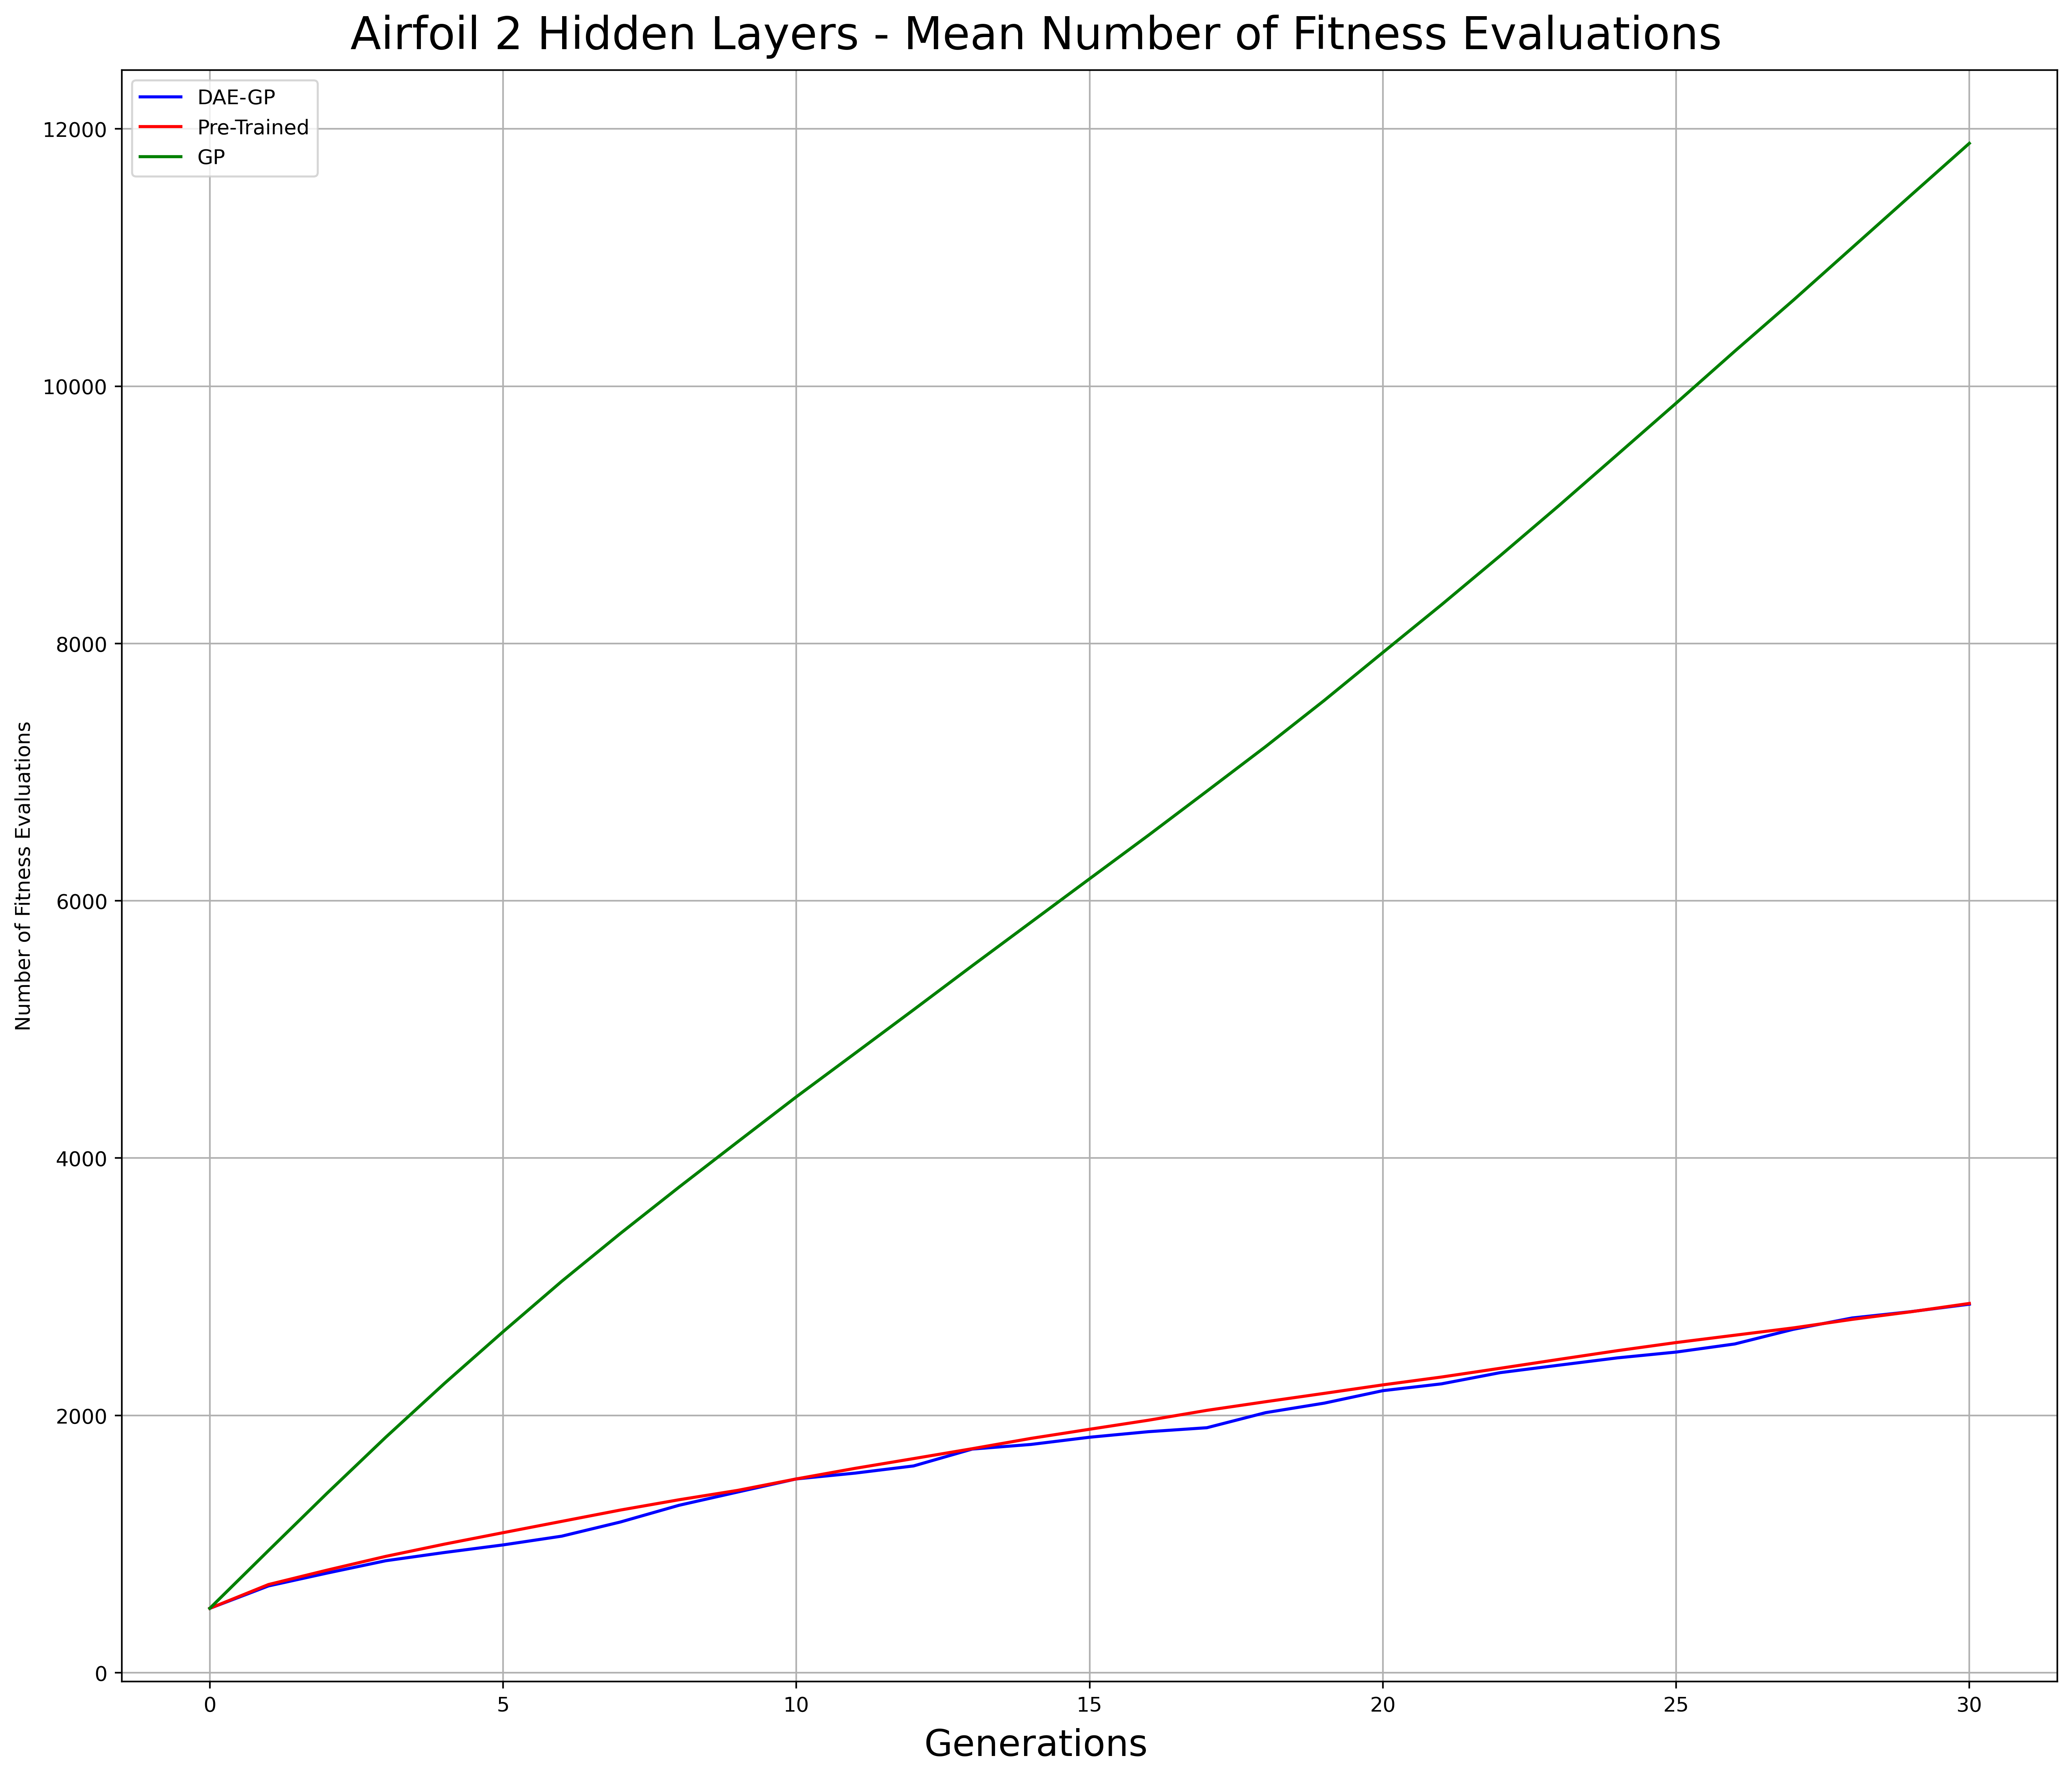

In [16]:
# number of evals per generation


reg_nevals = get_vals(reg_results, "fitness_nevals", 30)
pt_nevals = get_vals(pt_results, "fitness_nevals", 30)
gp_nevals = get_vals(gp_results, "fitness_nevals", 30)


reg_nevals_mean = get_means(reg_nevals)
pt_nevals_mean = get_means(pt_nevals)
gp_nevals_mean = get_means(gp_nevals)


fig, ax = plt.subplots(layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]


fig.suptitle(f"{BASE_TITLE} - Mean Number of Fitness Evaluations", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

ax.set_ylabel("Number of Fitness Evaluations")
ax.plot(gens, reg_nevals_mean, color=C_REG, label="DAE-GP")
ax.plot(gens, pt_nevals_mean, color=C_PT, label="Pre-Trained")
ax.plot(gens, gp_nevals_mean, color=C_GP, label="GP")

ax.grid()

ax.legend()


fig.savefig(f"{IMG_PATH}/mean_nevals_byGens.png")


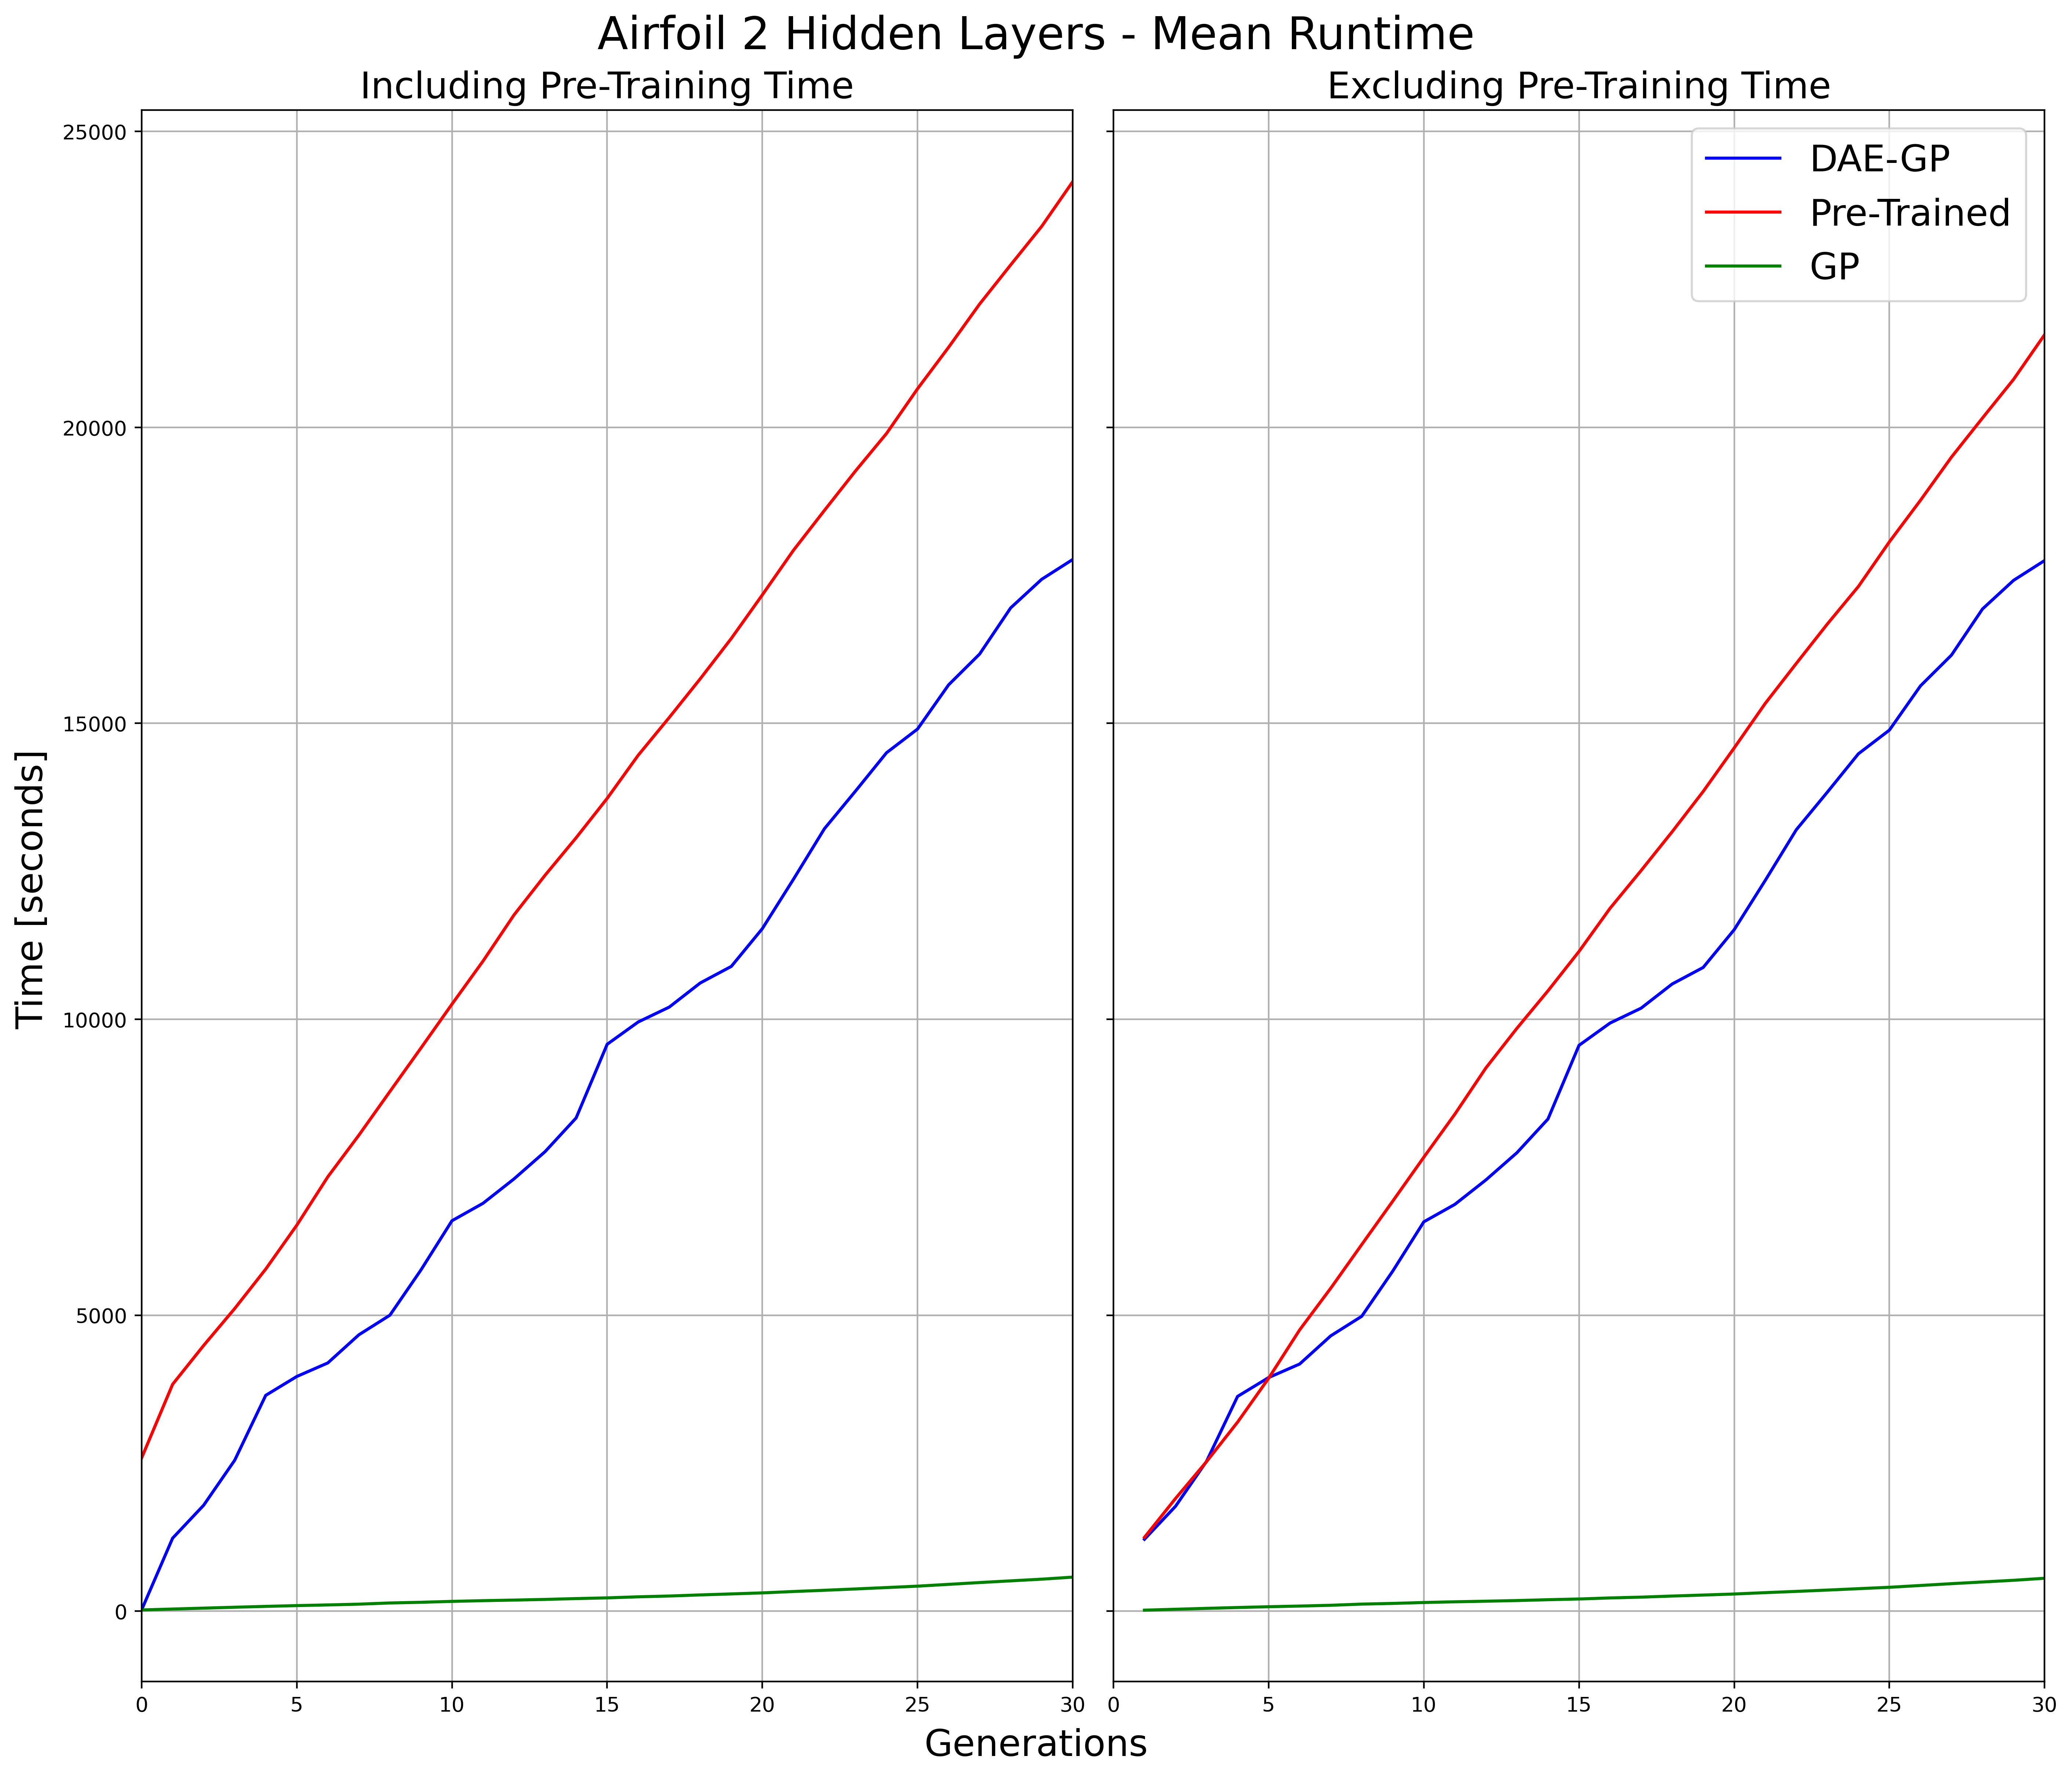

In [17]:
# plot mean total runtime

reg_time = get_vals(reg_results, "time_used", 30)
pt_time = get_vals(pt_results, "time_used", 30)
gp_time = get_vals(gp_results, "time_used", 30)


reg_time_mean = get_means(reg_time)
pt_time_mean = get_means(pt_time)
gp_time_mean = get_means(gp_time)



fig, (axl, axr) = plt.subplots(ncols=2, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

#axl.set_ylim(bottom=0, top=np.max(np.max(reg_time), np.max(pt_time), np.max(gp_time)))
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Mean Runtime", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

fig.supylabel("Time [seconds]", fontsize=MID)

axl.set_title("Including Pre-Training Time", fontsize=MID)
axl.plot(gens, reg_time_mean, color=C_REG, label="DAE-GP")
axl.plot(gens, pt_time_mean, color=C_PT, label="Pre-Trained")
axl.plot(gens, gp_time_mean, color=C_GP, label="GP")

axl.grid()

def subtract_and_remove(arr):
    new_arr = []
    for sub_arr in arr:
        first_val = sub_arr[0]
        new_sub_arr = [val - first_val for val in sub_arr[1:]]
        new_arr.append(new_sub_arr)
    return new_arr


reg_time_adj = subtract_and_remove(reg_time)     # [ arr[1:] for arr in reg_time ]
pt_time_adj = subtract_and_remove(pt_time)
gp_time_adj = subtract_and_remove(gp_time)       # [ arr[1:] for arr in gp_time ]


reg_time_adj_mean = np.mean(reg_time_adj, axis=0)
pt_time_adj_mean = np.mean(pt_time_adj, axis=0)
gp_time_adj_mean = np.mean(gp_time_adj, axis=0)


gens = [x for x in range(1, 31)]

axr.set_title("Excluding Pre-Training Time", fontsize=MID)
axr.plot(gens, reg_time_adj_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, pt_time_adj_mean, color=C_PT, label="Pre-Trained")
axr.plot(gens, gp_time_adj_mean, color=C_GP, label="GP")

axr.grid()
axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/mean_runtime.png")

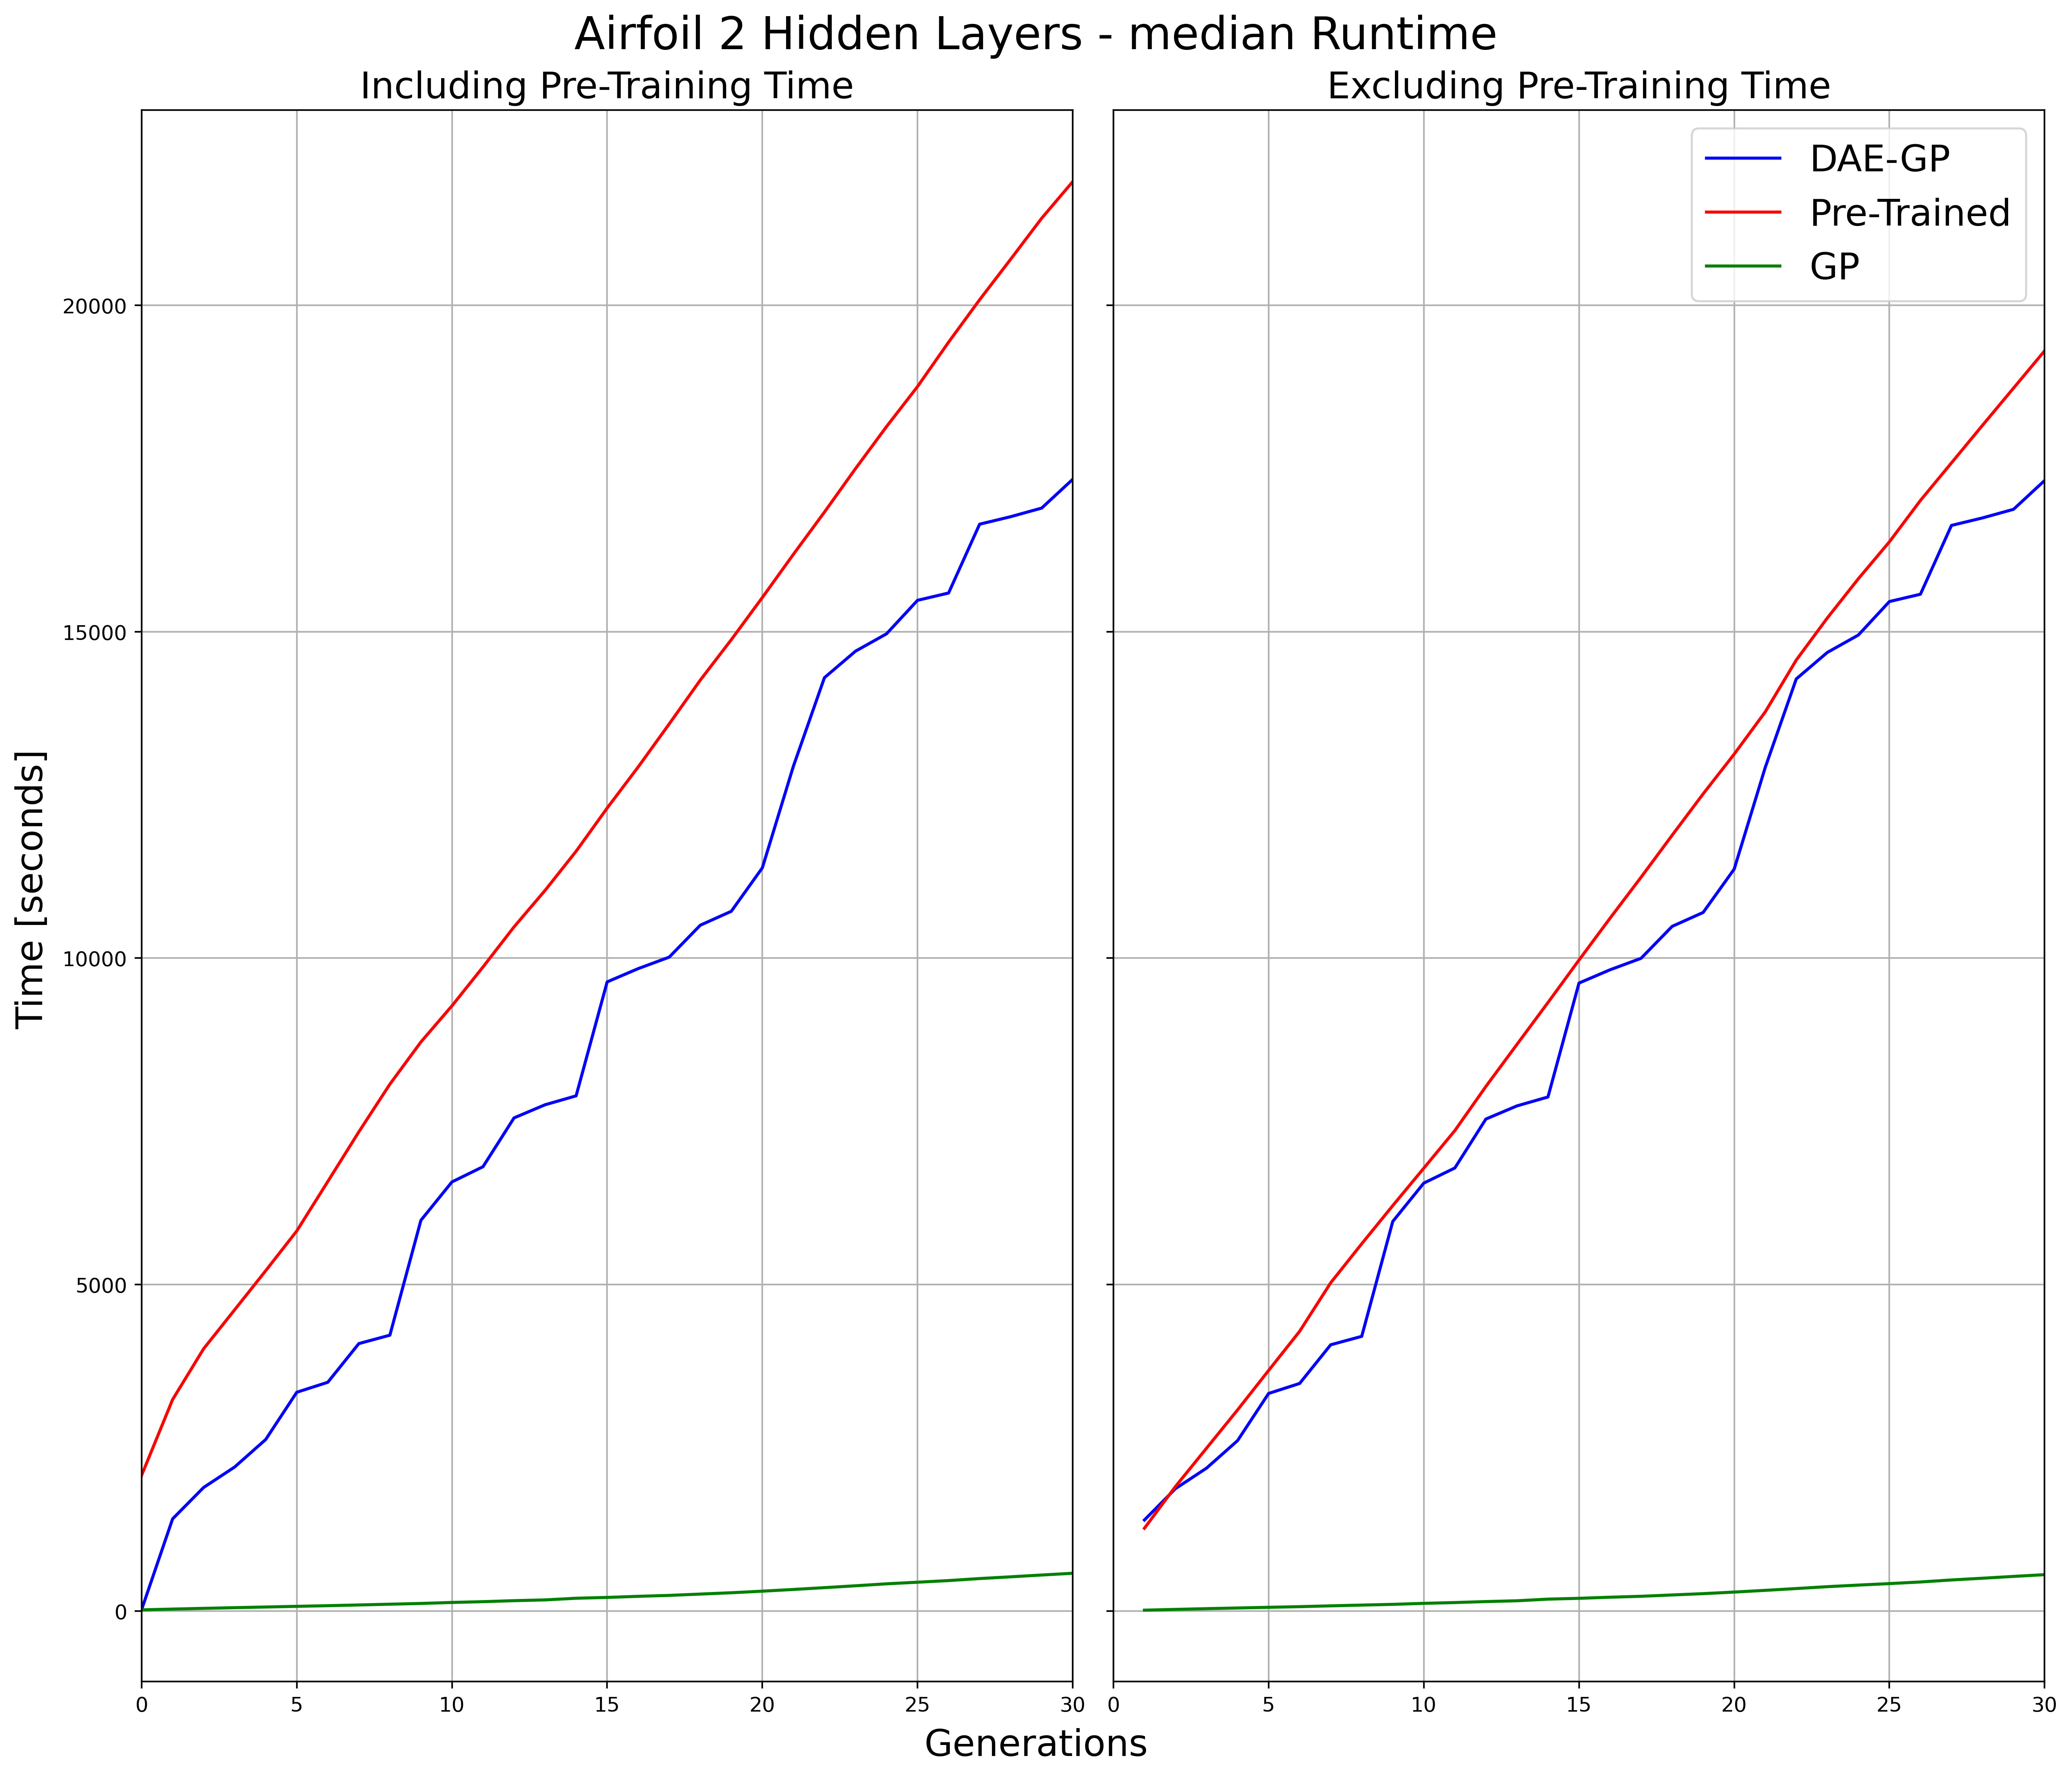

In [23]:
# plot median total runtime

reg_time = get_vals(reg_results, "time_used", 30)
pt_time = get_vals(pt_results, "time_used", 30)
gp_time = get_vals(gp_results, "time_used", 30)


reg_time_median = get_medians(reg_time)
pt_time_median = get_medians(pt_time)
gp_time_median = get_medians(gp_time)



fig, (axl, axr) = plt.subplots(ncols=2, layout="constrained", sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

# axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)
axr.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - median Runtime", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

fig.supylabel("Time [seconds]", fontsize=MID)

axl.set_title("Including Pre-Training Time", fontsize=MID)
axl.plot(gens, reg_time_median, color=C_REG, label="DAE-GP")
axl.plot(gens, pt_time_median, color=C_PT, label="Pre-Trained")
axl.plot(gens, gp_time_median, color=C_GP, label="GP")

axl.grid()

def subtract_and_remove(arr):
    new_arr = []
    for sub_arr in arr:
        first_val = sub_arr[0]
        new_sub_arr = [val - first_val for val in sub_arr[1:]]
        new_arr.append(new_sub_arr)
    return new_arr


reg_time_adj = subtract_and_remove(reg_time)     # [ arr[1:] for arr in reg_time ]
pt_time_adj = subtract_and_remove(pt_time)
gp_time_adj = subtract_and_remove(gp_time)       # [ arr[1:] for arr in gp_time ]


reg_time_adj_median = np.median(reg_time_adj, axis=0)
pt_time_adj_median = np.median(pt_time_adj, axis=0)
gp_time_adj_median = np.median(gp_time_adj, axis=0)


gens = [x for x in range(1, 31)]

axr.set_title("Excluding Pre-Training Time", fontsize=MID)
axr.plot(gens, reg_time_adj_median, color=C_REG, label="DAE-GP")
axr.plot(gens, pt_time_adj_median, color=C_PT, label="Pre-Trained")
axr.plot(gens, gp_time_adj_median, color=C_GP, label="GP")

axr.grid()
axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/median_runtime.png")

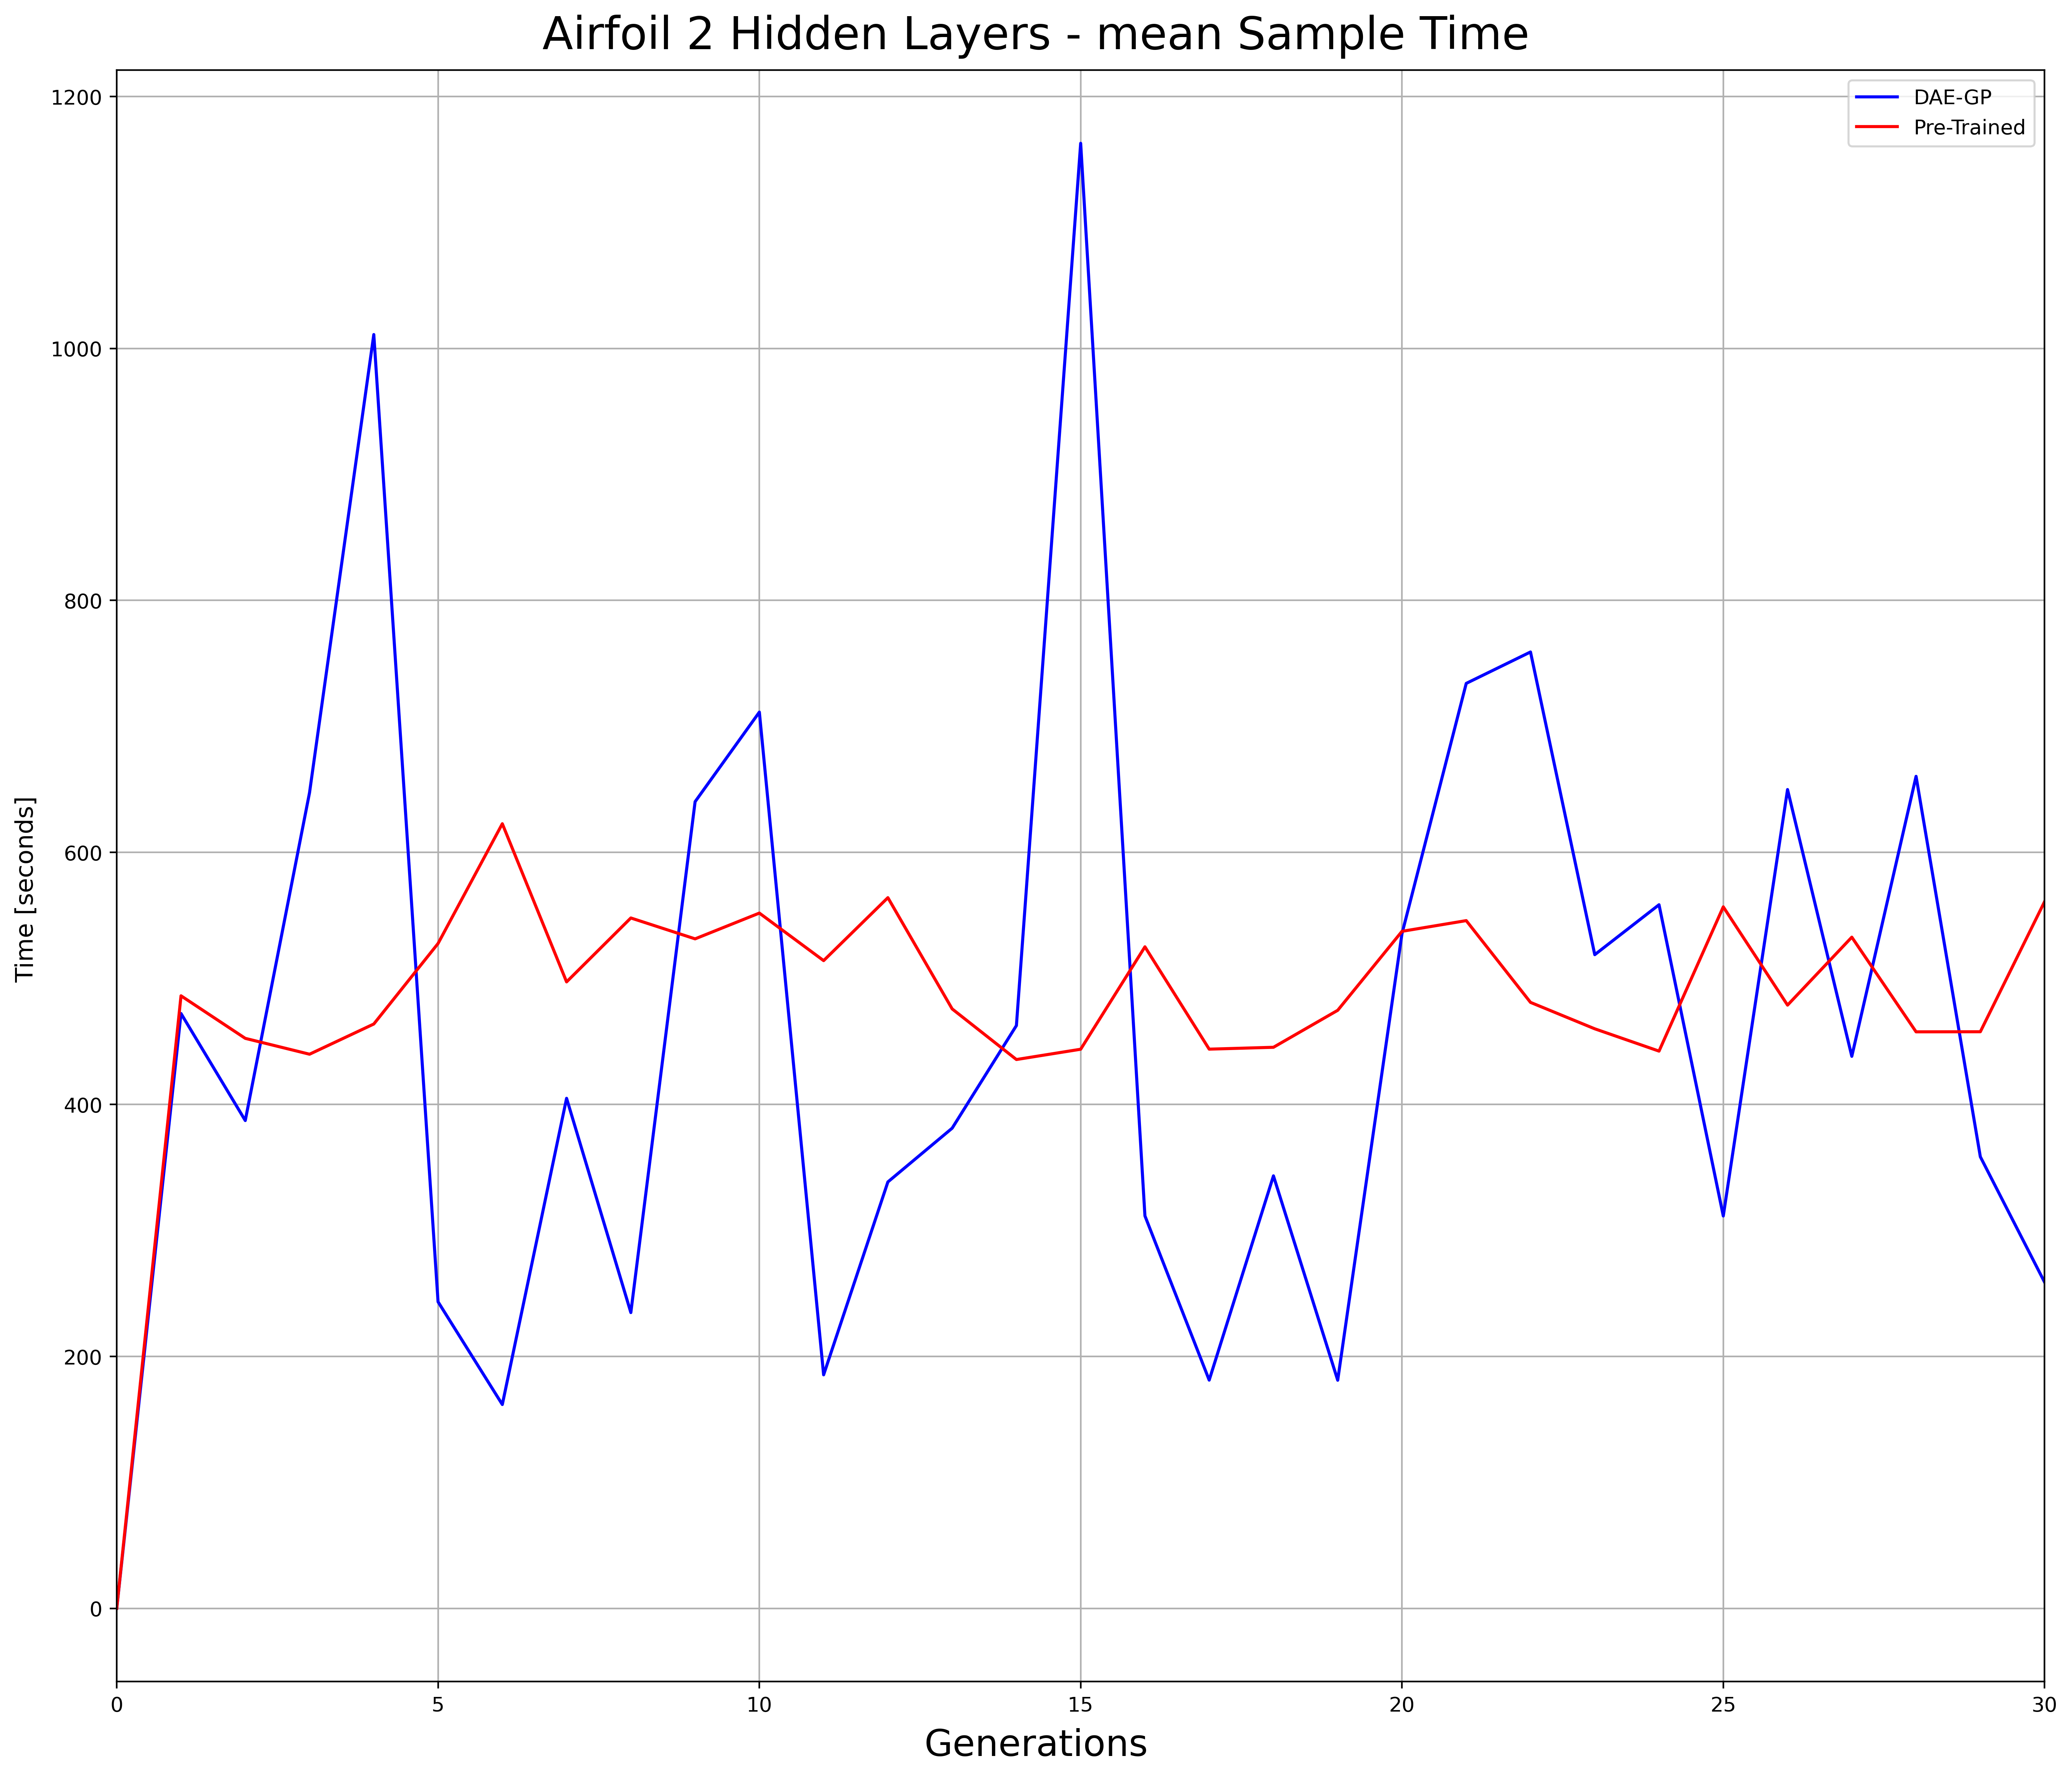

In [19]:
# plot mean sample time

reg_time = get_vals(reg_results, "sample_time", 30)
pt_time = get_vals(pt_results, "sample_time", 30)


reg_time_mean = get_means(reg_time)
pt_time_mean = get_means(pt_time)



fig, (axl) = plt.subplots(ncols=1, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

# axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - mean Sample Time", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

fig.supylabel("Time [seconds]")

axl.plot(gens, reg_time_mean, color=C_REG, label="DAE-GP")
axl.plot(gens, pt_time_mean, color=C_PT, label="Pre-Trained")

axl.grid()
axl.legend()


fig.savefig(f"{IMG_PATH}/mean_sampleTime.png")

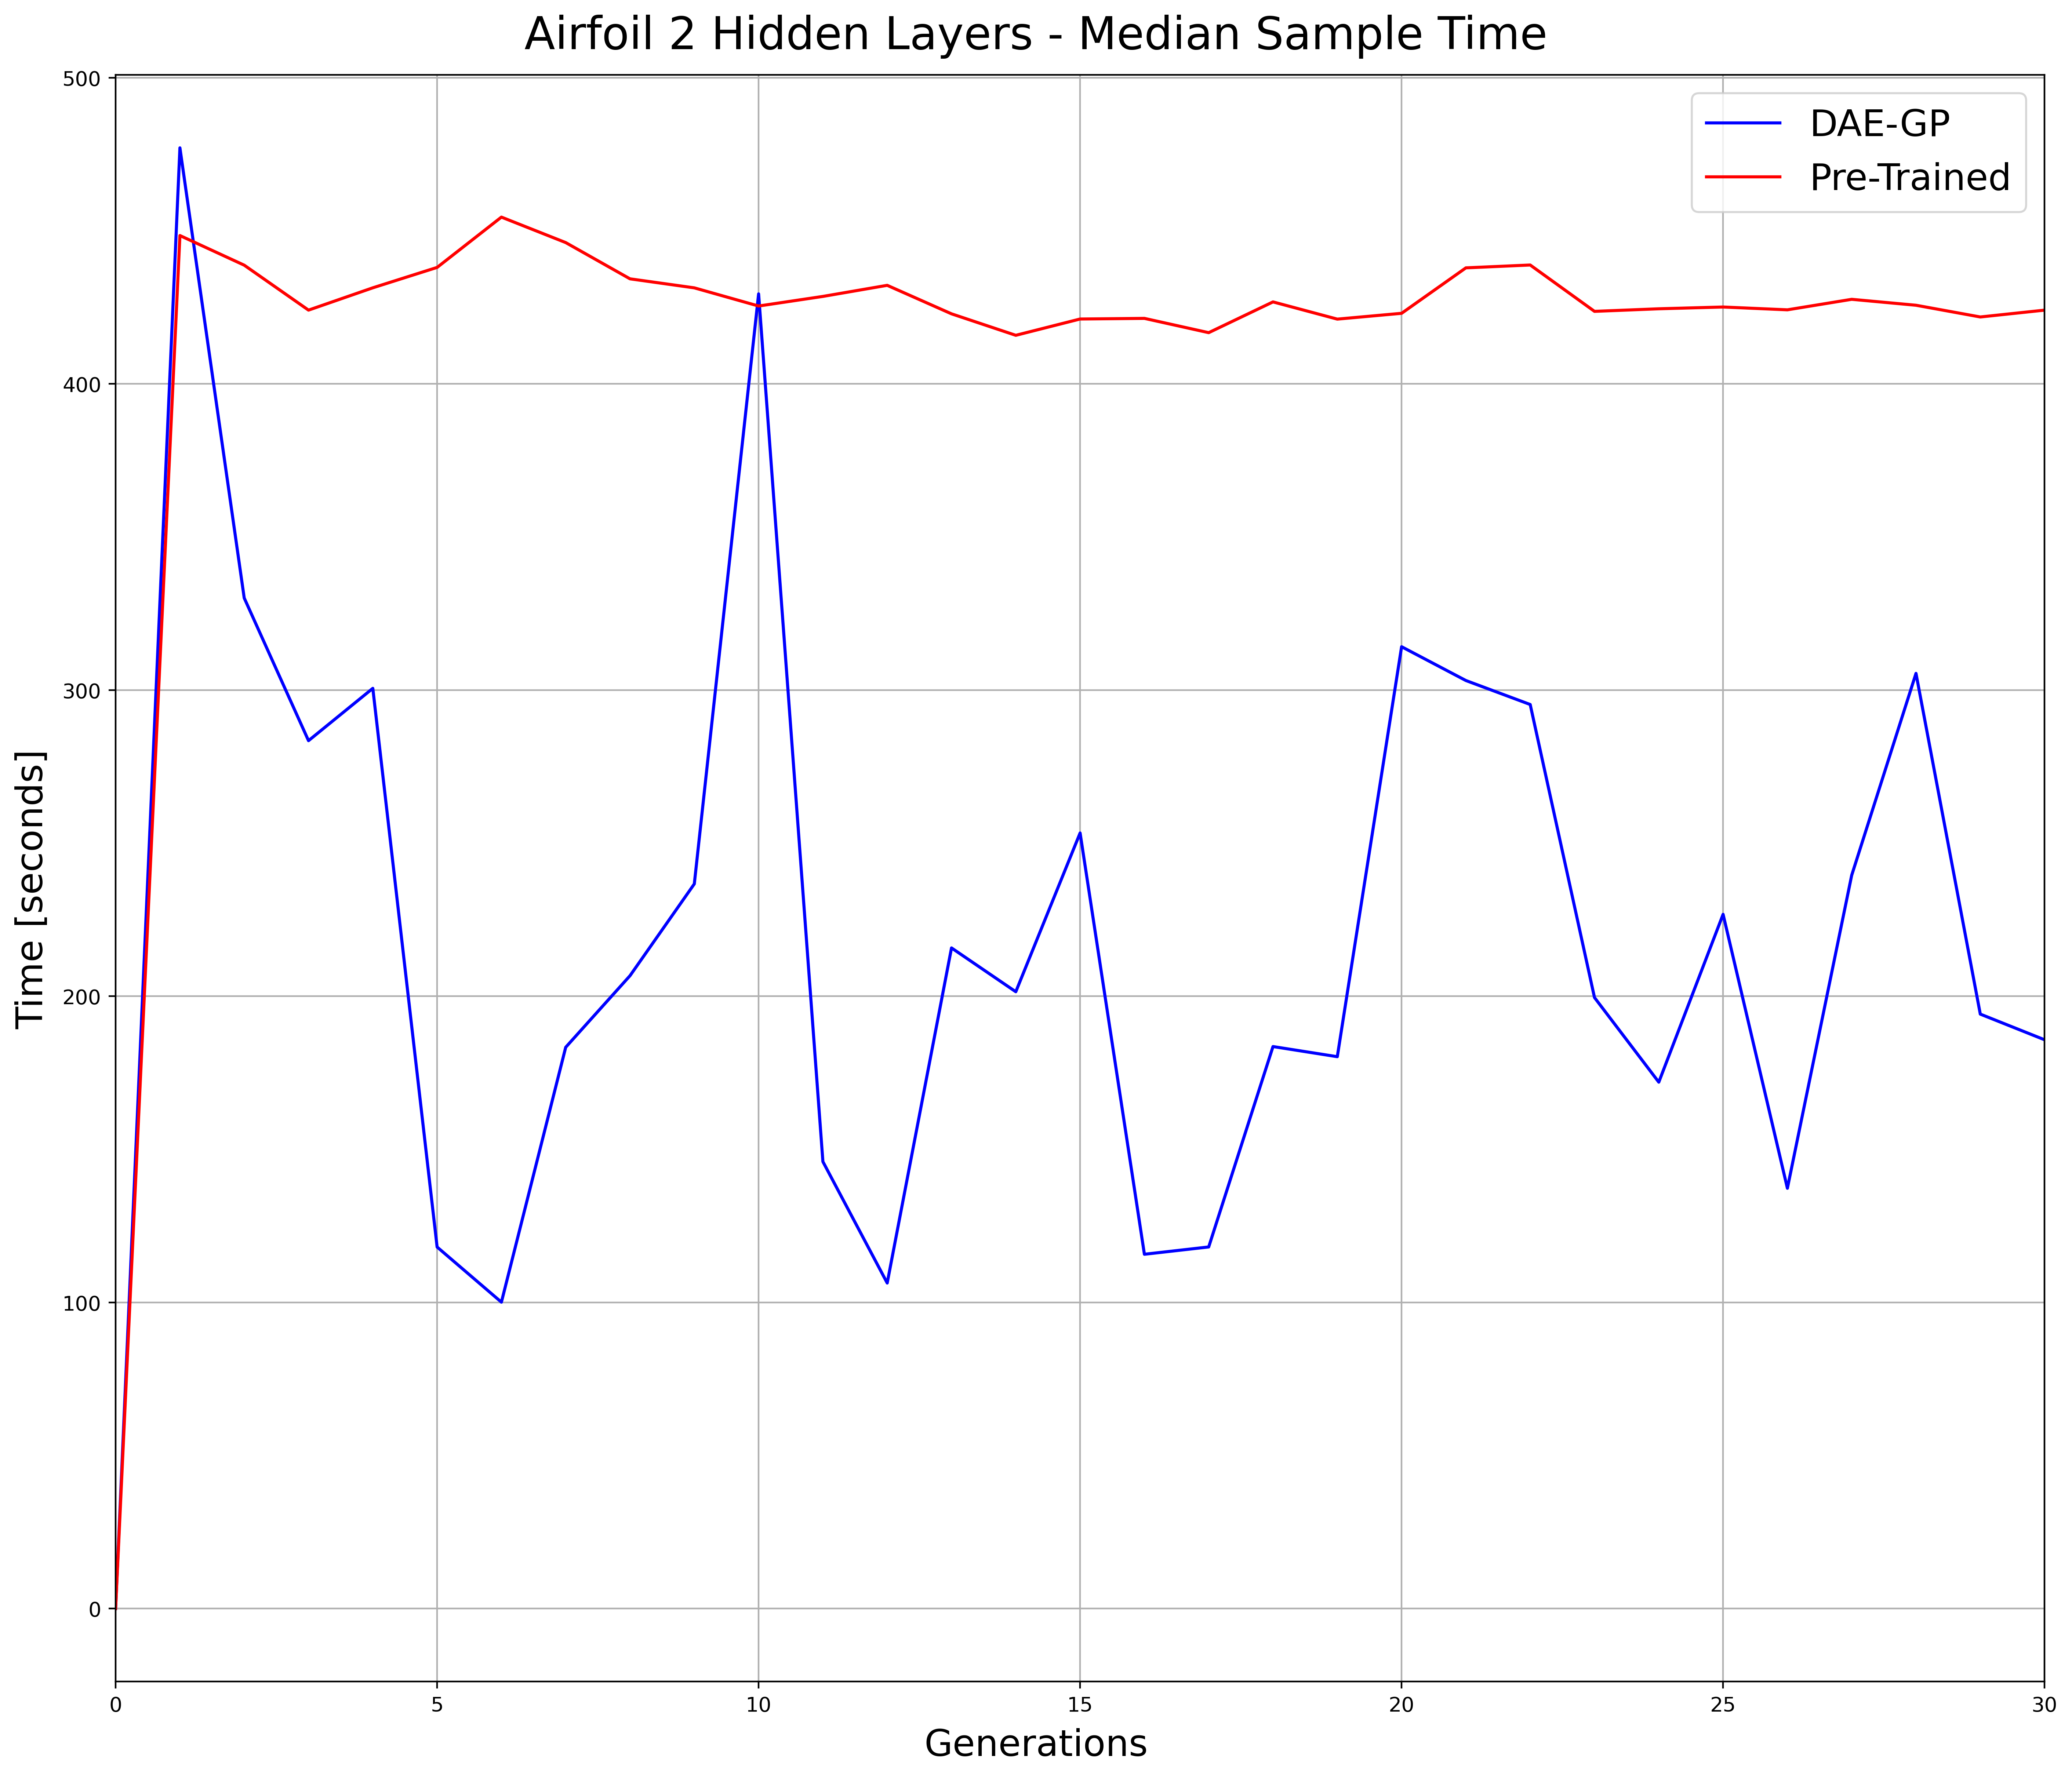

In [20]:
# plot median sample time

reg_time = get_vals(reg_results, "sample_time", 30)
pt_time = get_vals(pt_results, "sample_time", 30)


reg_time_mean = get_medians(reg_time)
pt_time_mean = get_medians(pt_time)



fig, (axl) = plt.subplots(ncols=1, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

# axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Median Sample Time", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

fig.supylabel("Time [seconds]", fontsize=MID)

axl.plot(gens, reg_time_mean, color=C_REG, label="DAE-GP")
axl.plot(gens, pt_time_mean, color=C_PT, label="Pre-Trained")

axl.grid()
axl.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/median_sampleTime.png")

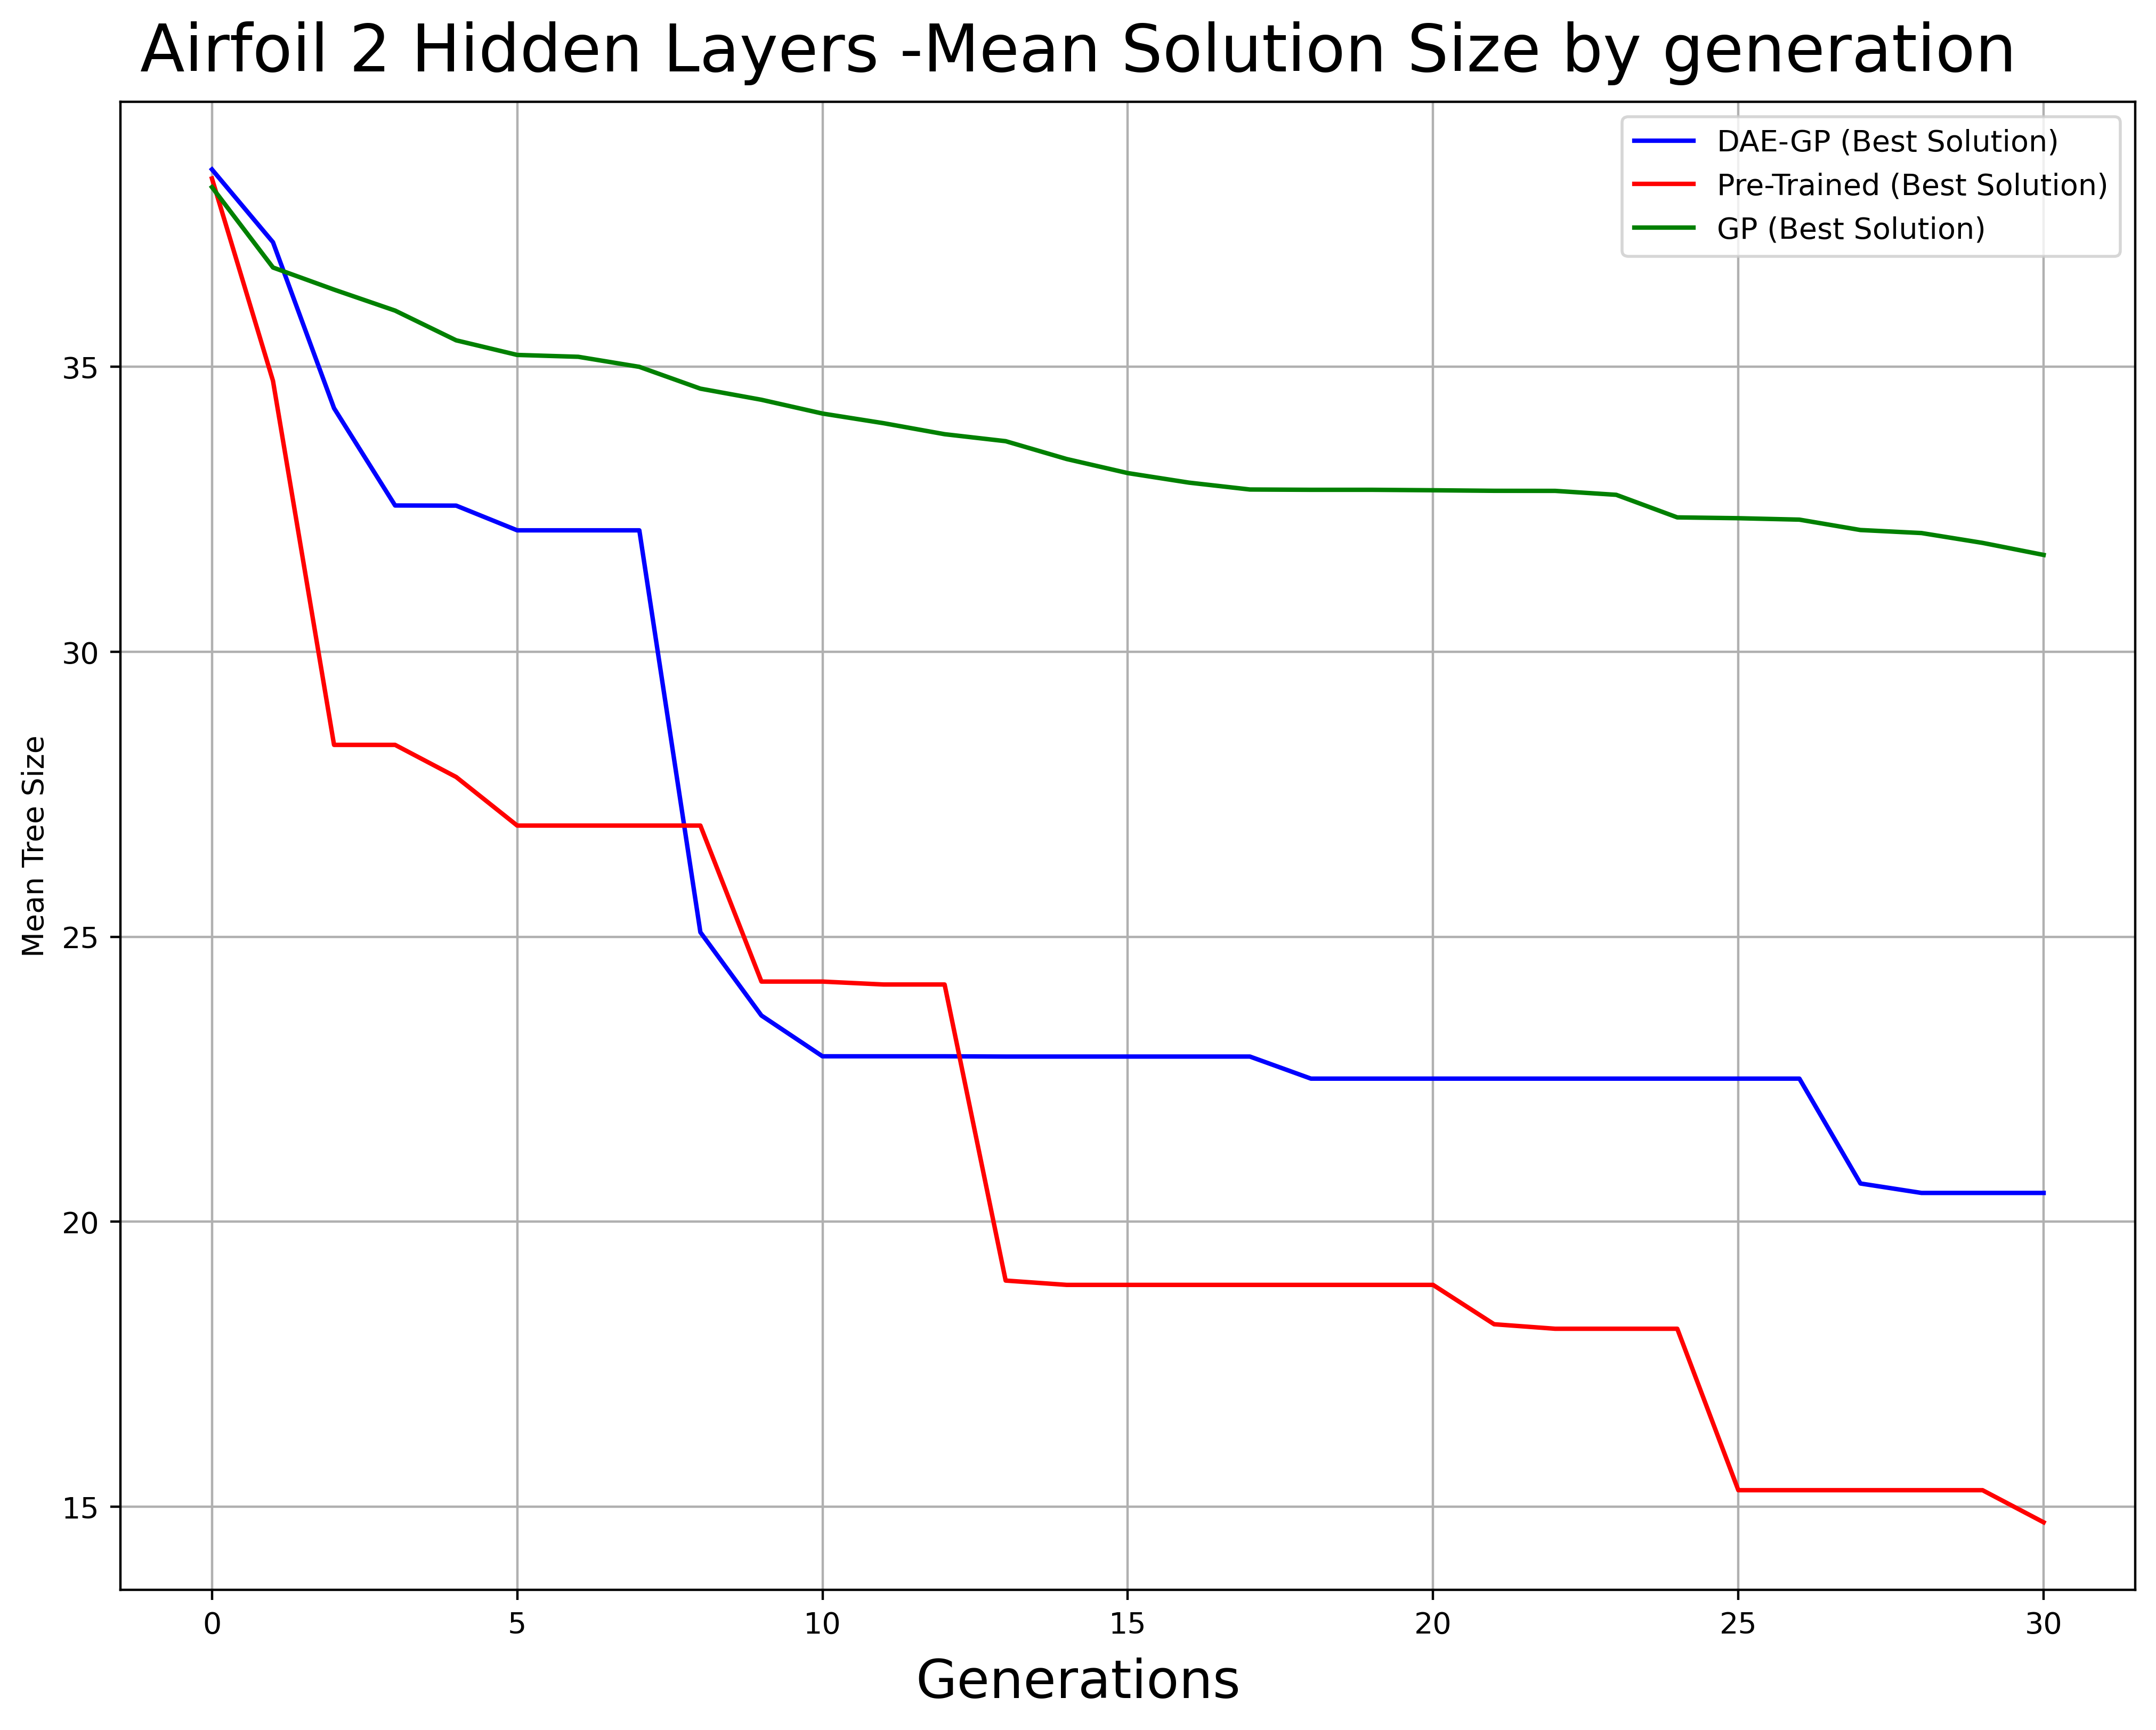

In [21]:
# plot avg size


reg_avgsize = get_vals(reg_results, "avg_size", 30)
pt_avgsize = get_vals(pt_results, "avg_size", 30)
gp_avgsize = get_vals(gp_results, "avg_size", 30)

reg_bestsize = get_vals(reg_results, "size_best_fitness", 30)
pt_bestsize = get_vals(pt_results, "size_best_fitness", 30)
gp_bestsize = get_vals(gp_results, "size_best_fitness", 30)

reg_avgsize_mean = get_means(reg_avgsize)
pt_avgsize_mean = get_means(pt_avgsize)
gp_avgsize_mean = get_means(gp_avgsize)

reg_bestsize_mean = get_means(reg_bestsize)
pt_bestsize_mean = get_means(pt_bestsize)
gp_bestsize_mean = get_means(gp_bestsize)





fig, (axl) = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(10,8)
gens = [x for x in range(0, 31)]

# ax.set_ylim(bottom=0)
# ax.set_xlim(left=0)


fig.suptitle(f"{BASE_TITLE} -Mean Solution Size by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axl.set_ylabel("Mean Tree Size")
axl.plot(gens, reg_bestsize_mean, color=C_REG, label="DAE-GP (Best Solution)")
#axl.plot(gens, reg_avgsize_mean, color=C_REG,linestyle=TRAIN_LINESTYLE, label="DAE-GP (Population average)")

axl.plot(gens, pt_bestsize_mean, color=C_PT, label="Pre-Trained (Best Solution)")
#axl.plot(gens, pt_avgsize_mean, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained (Population average)")

axl.plot(gens, gp_bestsize_mean, color=C_GP, label="GP (Best Solution)")
#axl.plot(gens, gp_avgsize_mean, color=C_GP, linestyle=TRAIN_LINESTYLE, label="GP (Population average)")



axl.grid()

axl.legend()


fig.savefig(f"{IMG_PATH}/mean_Size_byGens.png")


In [22]:
import datetime

def print_current_date_and_time():
  now = datetime.datetime.now()
  print(f'Notebook last executed at: {now.strftime("%Y-%m-%d %H:%M:%S")}')

print_current_date_and_time()

Notebook last executed at: 2023-01-20 14:02:26
